In [66]:
using Printf
using Random
using Statistics
using LinearAlgebra

using Flux
using DifferentialEquations
using DiffEqFlux

using JLD2
using BSON
using Plots

using Flux: @epochs

In [67]:
#####
##### Load data from JLD2 file
#####

file = jldopen("../data/ocean_convection_profiles.jld2")

Is = keys(file["timeseries/t"])

Nz = file["grid/Nz"]
Lz = file["grid/Lz"]
Nt = length(Is)

t = zeros(Nt)
T = T_data = zeros(Nt, Nz)
wT = zeros(Nt, Nz)

for (i, I) in enumerate(Is)
    t[i] = file["timeseries/t/$I"]
    T[i, :] = file["timeseries/T/$I"][1, 1, 2:Nz+1]
    wT[i, :] = file["timeseries/wT/$I"][1, 1, 2:Nz+1]
end

In [68]:
#####
##### Plot animation of T(z,t) from data
#####

z = file["grid/zC"]

anim = @animate for n=1:10:Nt
    t_str = @sprintf("%.2f", t[n] / 86400)
    plot(T[n, :], z, linewidth=2,
         xlim=(19, 20), ylim=(-100, 0), label="",
         xlabel="Temperature (C)", ylabel="Depth (z)",
         title="Deepening mixed layer: $t_str days", show=false)
end

gif(anim, "deepening_mixed_layer.gif", fps=15)

┌ Info: Saved animation to 
│   fn = /home/alir/6S898-climate-parameterization/notebooks/deepening_mixed_layer.gif
└ @ Plots /home/alir/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/home/alir/6S898-climate-parameterization/notebooks/deepening_mixed_layer.gif")

In [69]:
#####
##### Coarse grain data to 32 vertical levels (plus halo regions)
#####

function coarse_grain(data, resolution)
    @assert length(data) % resolution == 0
    s = length(data) / resolution
    
    data_cs = zeros(resolution)
    for i in 1:resolution
        t = data[Int((i-1)*s+1):Int(i*s)]
        data_cs[i] = mean(t)
    end
    
    return data_cs
end

coarse_grain (generic function with 1 method)

In [71]:
coarse_resolution = cr = 32

T_cs = zeros(coarse_resolution+2, Nt)
wT_cs = zeros(coarse_resolution+2, Nt)

z_cs = coarse_grain(collect(z), cr)

for n=1:Nt
    T_cs[2:end-1, n] .= coarse_grain(T[n, :], coarse_resolution)
    wT_cs[2:end-1, n] .= coarse_grain(wT[n, :], coarse_resolution)
end

# Fill halo regions to enforce boundary conditions.
T_cs[1,   :] .= T_cs[2,     :]
T_cs[end, :] .= T_cs[end-1, :]

wT_cs[1,   :] .= wT_cs[2,     :]
wT_cs[end, :] .= wT_cs[end-1, :];

In [6]:
#####
##### Plot coarse temperature and wT profiles
#####

@info "Plotting coarse temperature profile..."

anim = @animate for n=1:10:Nt
    t_str = @sprintf("%.2f", t[n] / 86400)
    plot(T_cs[2:cr+1, n], z_cs, linewidth=2,
         xlim=(19, 20), ylim=(-100, 0), label="",
         xlabel="Temperature (C)", ylabel="Depth (z)",
         title="Deepening mixed layer: $t_str days", show=false)
end

gif_T = gif(anim, "deepening_mixed_layer_T_coarse.gif", fps=15)

display(gif_T)

@info "Plotting coarse wT profile..."

anim = @animate for n=1:10:Nt
    t_str = @sprintf("%.2f", t[n] / 86400)
    plot(wT_cs[2:cr+1, n], z_cs, linewidth=2,
         xlim=(-1e-4, 1e-4), ylim=(-100, 0), label="",
         xlabel="Temperature (C)", ylabel="Depth (z)",
         title="Deepening mixed layer: $t_str days", show=false)
end

gif_wT = gif(anim, "deepening_mixed_layer_wT_coarse.gif", fps=15)

display(gif_wT)

┌ Info: Plotting coarse temperature profile...
└ @ Main In[6]:5


Plots.AnimatedGif("/home/alir/6S898-climate-parameterization/notebooks/deepening_mixed_layer_T_coarse.gif")

┌ Info: Saved animation to 
│   fn = /home/alir/6S898-climate-parameterization/notebooks/deepening_mixed_layer_T_coarse.gif
└ @ Plots /home/alir/.julia/packages/Plots/Iuc9S/src/animation.jl:95
┌ Info: Plotting coarse wT profile...
└ @ Main In[6]:19


Plots.AnimatedGif("/home/alir/6S898-climate-parameterization/notebooks/deepening_mixed_layer_wT_coarse.gif")

┌ Info: Saved animation to 
│   fn = /home/alir/6S898-climate-parameterization/notebooks/deepening_mixed_layer_wT_coarse.gif
└ @ Plots /home/alir/.julia/packages/Plots/Iuc9S/src/animation.jl:95


In [72]:
#####
##### Generate differentiation matrices
#####

cr_Δz = Lz / cr  # Coarse resolution Δz

# Dzᶠ computes the derivative from cell center to cell (F)aces
Dzᶠ = 1/cr_Δz * Tridiagonal(-ones(cr+1), ones(cr+2), zeros(cr+1))

# Dzᶜ computes the derivative from cell faces to cell (C)enters
Dzᶜ = 1/cr_Δz * Tridiagonal(zeros(cr+1), -ones(cr+2), ones(cr+1))

34×34 Tridiagonal{Float64,Array{Float64,1}}:
 -0.32   0.32    ⋅      ⋅      ⋅    …    ⋅      ⋅      ⋅      ⋅      ⋅  
  0.0   -0.32   0.32    ⋅      ⋅         ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅     0.0   -0.32   0.32    ⋅         ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅     0.0   -0.32   0.32       ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅     0.0   -0.32       ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅      ⋅     0.0   …    ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅      ⋅      ⋅    …    ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅      ⋅  
  ⋮   

In [300]:
#####
##### Create training and pre-training data
#####

Tₙ    = zeros(cr+2, Nt-1)
Tₙ₊₁  = zeros(cr+2, Nt-1)
wTₙ   = zeros(cr+2, Nt-1)
∂zTₙ  = zeros(cr+2, Nt-1)
∂zwTₙ = zeros(cr+2, Nt-1)

for i in 1:Nt-1
       Tₙ[:, i] .=  T_cs[:,   i]
     Tₙ₊₁[:, i] .=  T_cs[:, i+1]
      wTₙ[:, i] .= wT_cs[:,   i]
     ∂zTₙ[:, i] .= Dzᶠ * T_cs[:, i]
    ∂zwTₙ[:, i] .= Dzᶜ * wT_cs[:, i]
end

N = 32  # Number of training data pairs.

N_skip = 100  # Skip first N_skip iterations to avoid learning transients.
Ns = N_skip:N+N_skip

pre_training_data = [(Tₙ[:, i], -wTₙ[:, i]) for i in Ns]

# training_data = [(Tₙ[:, i], Tₙ₊₁[:, i]) for i in Ns]

N_postdata = 10
training_data = [(Tₙ[:, i], Tₙ₊₁[:, i:i+N_postdata-1]) for i in Ns]

# rinds = randperm(Nt)[1:N]
# pre_training_data = [(Tₙ[:, i], -wTₙ[:, i]) for i in rinds]
# training_data = [(Tₙ[:, i], Tₙ₊₁[:, i]) for i in rinds];

In [301]:
#####
##### Create heat flux vector
#####

heat_flux = zeros(cr+2)

Q  = -100
ρ₀ = file["parameters/density"]
cₚ = file["parameters/specific_heat_capacity"]

heat_flux[cr+1] = Q / (ρ₀ * cₚ * cr_Δz)

-7.789678675754626e-6

In [302]:
#####
##### Create neural network
#####

# Complete black box right-hand-side.
dTdt_NN = Chain(Dense(cr+2,  2cr, tanh),
                Dense(2cr,  cr+2))

# Use NN to parameterize the horizontally averaged buoyancy flux (wT).
wT_NN = Chain(T -> Dzᶠ*T,
              Dense(cr+2, 4cr, relu),
              Dense(4cr,  4cr, relu),
              Dense(4cr,  cr+2))

dTdt_NN = Chain(wT_NN_copy,
                x -> Dzᶜ * x .+ heat_flux)


wT_NN_params = Flux.params(wT_NN);

In [303]:
#####
##### Pre-train the neural network on (T, wT) data pairs
#####

pre_loss_function(Tₙ, wTₙ) = sum(abs2, wT_NN(Tₙ) .- wTₙ) ./ sum(abs2, wTₙ)

popt = ADAM(0.01)

function precb()
    loss = sum([pre_loss_function(pre_training_data[i]...) for i in 1:N])
    println("loss = $loss")
    return loss
end

precb()

loss = 1.281931322605036e11 (tracked)


1.281931322605036e11 (tracked)

In [304]:
popt.eta = 0.01

pre_train_epochs = 20
for _ in 1:pre_train_epochs
    Flux.train!(pre_loss_function, wT_NN_params, pre_training_data, popt, cb = Flux.throttle(precb, 5))
end

loss = 5.503295470458842e10 (tracked)
loss = 4.2621157887962125e7 (tracked)
loss = 1.5683147621646323e6 (tracked)
loss = 63213.492849262344 (tracked)
loss = 1543.104135589055 (tracked)
loss = 67.42251376491953 (tracked)
loss = 1.6929434264218621 (tracked)
loss = 0.4100937097697959 (tracked)
loss = 0.3763383760088059 (tracked)
loss = 0.37298366350715934 (tracked)
loss = 0.3662492964003819 (tracked)
loss = 0.3565557867821488 (tracked)
loss = 0.34463079660328566 (tracked)
loss = 0.33162941679993146 (tracked)
loss = 0.3187932388995644 (tracked)
loss = 0.3070463052353831 (tracked)
loss = 0.2968151303366508 (tracked)
loss = 0.2881410233738012 (tracked)
loss = 0.2808866638928733 (tracked)
loss = 0.2748839162252509 (tracked)


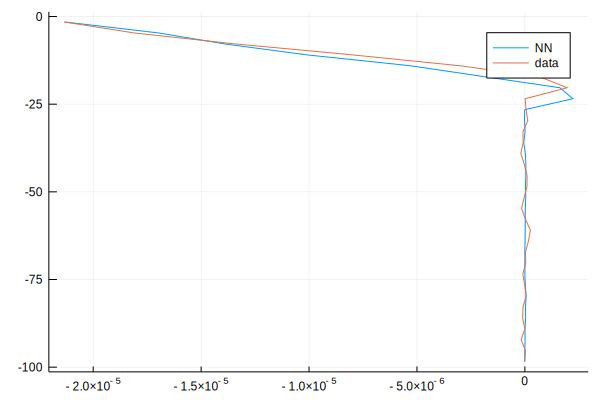

In [307]:
#####
##### Compare wT_NN output with wT data
#####

z_cs = coarse_grain(z, cr)

n = 1

wT = wT_NN(pre_training_data[n][1]) |> Flux.data

plot(wT[2:cr+1], z_cs, label="NN")
plot!(pre_training_data[n][2][2:cr+1], z_cs, label="data")

In [414]:
#####
##### Define neural network for dTdt RHS in terms of wT_NN
#####

wT_NN_copy = deepcopy(wT_NN)

dTdt_NN = Chain(wT_NN_copy,
                x -> Dzᶜ * x .+ heat_flux)

dTdt_NN_params = Flux.params(dTdt_NN);

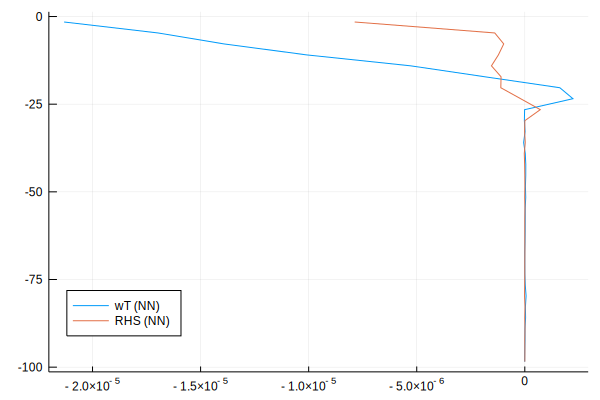

In [415]:
#####
##### Compare output of wT_NN and dTdt_NN
#####

wT = wT_NN(Tₙ[:, 150]) |> Flux.data
RHS = dTdt_NN(Tₙ[:, 150]) |> Flux.data

plot(wT[2:cr+1], z_cs, label="wT (NN)", legend=:bottomleft)
plot!(RHS[2:cr+1], z_cs, label="RHS (NN)")

In [416]:
#####
##### Define loss function for neural ODE
#####

# tspan = (0.0, 600.0)  # 10 minutes
# neural_pde_prediction(T₀) = neural_ode(dTdt_NN, T₀, tspan, Tsit5(), reltol=1e-4, save_start=false, saveat=tspan[2])

tspan = (0.0, N_postdata*600.0)  # 10 minutes
t_save = range(600.0, tspan[2], length=N_postdata)
neural_pde_prediction(T₀) = neural_ode(dTdt_NN, T₀, tspan, Tsit5(), reltol=1e-4, save_start=false, saveat=t_save)

loss_function(Tₙ, Tₙ₊₁) = sum(abs2, Tₙ₊₁ .- neural_pde_prediction(Tₙ))

loss_function (generic function with 1 method)

In [425]:
#####
##### Choose optimization algorithm
#####

opt = ADAM(1e-8)
# opt = Descent(0.00000001)

ADAM(1.0e-8, (0.9, 0.999), IdDict{Any,Any}())

In [426]:
#####
##### Callback function to observe training.
#####

N_test = 32

function cb()
    train_loss = sum([loss_function(Tₙ[:, i], Tₙ₊₁[:, i]) for i in Ns])
    println("train_loss = $train_loss")
    
    # nn_pred = neural_ode(dTdt_NN, Tₙ[:, N_skip+1], (t[1], t[N_test]), Tsit5(), saveat=t[1:N_test], reltol=1e-4) |> Flux.data
    # test_loss = sum(abs2, T_cs[:, 1:N_test] .- nn_pred)
    # println("train_loss = $train_loss, test_loss = $test_loss")
    
    return train_loss
end

cb()

train_loss = 0.037935356382914266 (tracked)


0.037935356382914266 (tracked)

In [427]:
#####
##### Train!
#####
opt.eta = 1e-9

epochs = 5
best_loss = Inf
last_improvement = 0

for epoch_idx in 1:epochs
    global best_loss, last_improvement

    @info "Epoch $epoch_idx"
    Flux.train!(loss_function, dTdt_NN_params, training_data, opt, cb=cb)
    
    loss = cb()

    if loss <= best_loss
        @info("Record low loss! Saving neural network out to dTdt_NN.bson")
        BSON.@save "dTdt_NN.bson" dTdt_NN
        best_loss = loss
        last_improvement = epoch_idx
    end
   
    # If we haven't seen improvement in 2 epochs, drop our learning rate:
    if epoch_idx - last_improvement >= 2 && opt.eta > 1e-6
        opt.eta /= 2.0
        @warn("Haven't improved in a while, dropping learning rate to $(opt.eta)")

        # After dropping learning rate, give it a few epochs to improve
        last_improvement = epoch_idx
    end
end

┌ Info: Epoch 1
└ @ Main In[427]:13


train_loss = 0.03792993627647463 (tracked)
train_loss = 0.03792454653794582 (tracked)
train_loss = 0.03791920958057826 (tracked)
train_loss = 0.03791395310331302 (tracked)
train_loss = 0.03790879559759386 (tracked)
train_loss = 0.037903817199065104 (tracked)
train_loss = 0.03789909441191994 (tracked)
train_loss = 0.03789477502314143 (tracked)
train_loss = 0.03789078980555029 (tracked)
train_loss = 0.03788732557253455 (tracked)
train_loss = 0.037884392382523766 (tracked)
train_loss = 0.037881936882668554 (tracked)
train_loss = 0.037879921761509464 (tracked)
train_loss = 0.037878306061848985 (tracked)
train_loss = 0.03787708605738915 (tracked)
train_loss = 0.03787626024243876 (tracked)
train_loss = 0.03787577992318848 (tracked)
train_loss = 0.03787556880151826 (tracked)
train_loss = 0.03787564888887249 (tracked)
train_loss = 0.037876028575583656 (tracked)
train_loss = 0.03787674071723097 (tracked)
train_loss = 0.037877771958062564 (tracked)
train_loss = 0.03787905799259443 (tracked)
trai

┌ Info: Record low loss! Saving neural network out to dTdt_NN.bson
└ @ Main In[427]:19
┌ Info: Epoch 2
└ @ Main In[427]:13


train_loss = 0.037886744028109494 (tracked)
train_loss = 0.03788454754583482 (tracked)
train_loss = 0.03788182701419847 (tracked)
train_loss = 0.03787873037177161 (tracked)
train_loss = 0.0378753758303546 (tracked)
train_loss = 0.03787186424598044 (tracked)
train_loss = 0.03786829699572926 (tracked)
train_loss = 0.037864807697751156 (tracked)
train_loss = 0.037861421135355566 (tracked)
train_loss = 0.03785823999362899 (tracked)
train_loss = 0.03785535655175613 (tracked)
train_loss = 0.037852802729129394 (tracked)
train_loss = 0.037850622389671476 (tracked)
train_loss = 0.037848840825231905 (tracked)
train_loss = 0.037847477257355835 (tracked)
train_loss = 0.03784651599389394 (tracked)
train_loss = 0.037845900951547676 (tracked)
train_loss = 0.03784556021727405 (tracked)
train_loss = 0.03784553784863731 (tracked)
train_loss = 0.037845807394767395 (tracked)
train_loss = 0.03784642237396901 (tracked)
train_loss = 0.037847352040536915 (tracked)
train_loss = 0.03784854422952928 (tracked)
tr

┌ Info: Record low loss! Saving neural network out to dTdt_NN.bson
└ @ Main In[427]:19
┌ Info: Epoch 3
└ @ Main In[427]:13


train_loss = 0.03785619780556146 (tracked)
train_loss = 0.03785408457116406 (tracked)
train_loss = 0.03785141484100258 (tracked)
train_loss = 0.037848339469380654 (tracked)
train_loss = 0.037844976401015855 (tracked)
train_loss = 0.03784143722137338 (tracked)
train_loss = 0.037837832686993124 (tracked)
train_loss = 0.037834310854084355 (tracked)
train_loss = 0.037830898962321786 (tracked)
train_loss = 0.03782769826392247 (tracked)
train_loss = 0.0378248059761987 (tracked)
train_loss = 0.03782225379493071 (tracked)
train_loss = 0.03782008772804029 (tracked)
train_loss = 0.03781833703794407 (tracked)
train_loss = 0.037817018892149994 (tracked)
train_loss = 0.037816114062807014 (tracked)
train_loss = 0.037815560619973654 (tracked)
train_loss = 0.03781528785922326 (tracked)
train_loss = 0.03781534350192566 (tracked)
train_loss = 0.037815699477066304 (tracked)
train_loss = 0.03781640746227041 (tracked)
train_loss = 0.03781743072531975 (tracked)
train_loss = 0.03781871734760004 (tracked)
tra

┌ Info: Record low loss! Saving neural network out to dTdt_NN.bson
└ @ Main In[427]:19
┌ Info: Epoch 4
└ @ Main In[427]:13


train_loss = 0.03782717125955796 (tracked)
train_loss = 0.03782511045885796 (tracked)
train_loss = 0.037822483116079976 (tracked)
train_loss = 0.03781943954828933 (tracked)
train_loss = 0.03781609564132721 (tracked)
train_loss = 0.03781256872632456 (tracked)
train_loss = 0.03780897476869742 (tracked)
train_loss = 0.03780546979570579 (tracked)
train_loss = 0.03780207780243079 (tracked)
train_loss = 0.03779890354033347 (tracked)
train_loss = 0.03779604485867631 (tracked)
train_loss = 0.03779353428422356 (tracked)
train_loss = 0.037791417185247644 (tracked)
train_loss = 0.03778972194662474 (tracked)
train_loss = 0.0377884682631311 (tracked)
train_loss = 0.03778763211699201 (tracked)
train_loss = 0.0377871472014163 (tracked)
train_loss = 0.03778694588222105 (tracked)
train_loss = 0.037787075038299194 (tracked)
train_loss = 0.03778750978165286 (tracked)
train_loss = 0.03778829779680737 (tracked)
train_loss = 0.037789402093578756 (tracked)
train_loss = 0.03779076916687229 (tracked)
train_los

┌ Info: Record low loss! Saving neural network out to dTdt_NN.bson
└ @ Main In[427]:19
┌ Info: Epoch 5
└ @ Main In[427]:13


train_loss = 0.0377998924505803 (tracked)
train_loss = 0.03779788266425603 (tracked)
train_loss = 0.03779530462347125 (tracked)
train_loss = 0.037792304582368194 (tracked)
train_loss = 0.0377889979899203 (tracked)
train_loss = 0.03778550574135342 (tracked)
train_loss = 0.037781947755985146 (tracked)
train_loss = 0.03777848009270652 (tracked)
train_loss = 0.037775129979778055 (tracked)
train_loss = 0.03777200017544001 (tracked)
train_loss = 0.03776919107254829 (tracked)
train_loss = 0.03776673252864361 (tracked)
train_loss = 0.03776467289214464 (tracked)
train_loss = 0.03776303979745668 (tracked)
train_loss = 0.03776185228010928 (tracked)
train_loss = 0.03776108216083299 (tracked)
train_loss = 0.037760664553344876 (tracked)
train_loss = 0.03776052943089403 (tracked)
train_loss = 0.037760727657072536 (tracked)
train_loss = 0.03776123332799097 (tracked)
train_loss = 0.03776209272771389 (tracked)
train_loss = 0.037763268313619903 (tracked)
train_loss = 0.0377647051725087 (tracked)
train_lo

┌ Info: Record low loss! Saving neural network out to dTdt_NN.bson
└ @ Main In[427]:19


In [424]:
#####
##### Run the neural PDE forward to see how well it performs just by itself.
#####

N_plot = 500

nn_pred = neural_ode(dTdt_NN, Tₙ[:, 1], (t[1], t[N_plot]), Tsit5(), saveat=t[1:N_plot], reltol=1e-4) |> Flux.data

anim = @animate for n=1:10:N_plot
    t_str = @sprintf("%.2f", t[n] / 86400)
    plot(T_cs[2:end-1, n], z_cs, linewidth=2,
         xlim=(19, 20), ylim=(-100, 0), label="Data",
         xlabel="Temperature (C)", ylabel="Depth (z)",
         title="Deepening mixed layer: $t_str days",
         legend=:bottomright, show=false)
    plot!(nn_pred[2:end-1, n], z_cs, linewidth=2, label="Neural PDE", show=false)
end

gif(anim, "deepening_mixed_layer_neural_PDE.gif", fps=15)

┌ Info: Saved animation to 
│   fn = /home/alir/6S898-climate-parameterization/notebooks/deepening_mixed_layer_neural_PDE.gif
└ @ Plots /home/alir/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/home/alir/6S898-climate-parameterization/notebooks/deepening_mixed_layer_neural_PDE.gif")